## Import modules and libraries

In [1]:
from utils_data_preparation import *
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
def timedelta_with_general_date(df, general_date=None, drop = True):
    dates = df.select_dtypes('datetime').columns
    dates = set(dates) - set([general_date])
    for i in dates:
        df['Diff_days'+general_date +'_bt_'+ i] = (df[general_date] - df[i]).astype('timedelta64[D]')
        df['Diff_month'+general_date +'_bt_'+ i] = (df[general_date] - df[i]).astype('timedelta64[M]')
        df['Diff_year'+general_date +'_bt_'+ i] = (df[general_date] - df[i]).astype('timedelta64[Y]')
    if drop: df.drop(dates, axis=1, inplace=True)
    return df

## Train

### Load data

In [4]:
df_train = pd.read_csv(path/'Train.csv', parse_dates=['Policy Start Date','Policy End Date',
                                                     'First Transaction Date'])

In [5]:
df_train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [6]:
df_train.shape

(12079, 14)

In [7]:
df_train.describe()

,Age,No_Pol,target
count,12079.00000,12079.00000,12079.00000
mean,42.23454,1.30723,0.12046
std,97.49256,0.73308,0.32551
min,-6099.00000,1.00000,0.00000
25%,35.00000,1.00000,0.00000
50%,41.00000,1.00000,0.00000
75%,50.00000,1.00000,0.00000
max,320.00000,10.00000,1.00000


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
ID                        12079 non-null object
Policy Start Date         12079 non-null datetime64[ns]
Policy End Date           12079 non-null datetime64[ns]
Gender                    11720 non-null object
Age                       12079 non-null int64
First Transaction Date    12079 non-null datetime64[ns]
No_Pol                    12079 non-null int64
Car_Category              8341 non-null object
Subject_Car_Colour        5117 non-null object
Subject_Car_Make          9603 non-null object
LGA_Name                  5603 non-null object
State                     5591 non-null object
ProductName               12079 non-null object
target                    12079 non-null int64
dtypes: datetime64[ns](3), int64(3), object(8)
memory usage: 1.3+ MB


In [9]:
min(df_train['Policy Start Date'])

Timestamp('2001-12-11 00:00:00')

In [10]:
max(df_train['Policy Start Date'])

Timestamp('2010-12-31 00:00:00')

### Train/val split

In [11]:
df_train.sort_values(by= 'Policy Start Date', inplace = True)

In [12]:
df_train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
8010,ID_O51ZQ1B,2001-12-11,2011-12-10,Female,37,2001-12-11,1,Saloon,Black,Honda,NaN,NaN,Car Vintage,0
10526,ID_VJ1FAVO,2002-03-25,2011-03-24,Male,37,2002-03-25,1,Saloon,Black,TOYOTA,Ekiti,Benue,Car Classic,0
10234,ID_ULWS8VL,2003-04-13,2011-04-12,Male,41,2003-04-13,2,Saloon,Black,TOYOTA,Ikeja,Lagos,Car Vintage,0
12066,ID_ZYKGSP7,2003-12-21,2034-05-20,Male,48,2003-12-21,2,Saloon,NaN,BMW,NaN,NaN,Car Vintage,0
8124,ID_OEWBKGF,2005-08-05,2011-09-29,Female,44,2005-08-05,1,NaN,NaN,Tata,Ajah,Lagos,CVTP,0


In [13]:
df_train.reset_index(inplace =True, drop = True)

In [14]:
n = round(len(df_train) * 0.8)
df_train,df_val = split_vals(df_train,n)

In [15]:
df_train.shape

(9663, 14)

In [16]:
df_val.shape

(2416, 14)

In [17]:
df_train['target'].value_counts()

0    8423
1    1240
Name: target, dtype: int64

In [18]:
df_val['target'].value_counts()

0    2201
1     215
Name: target, dtype: int64

In [19]:
df_train.reset_index(inplace = True, drop = True)

In [20]:
df_train.to_feather(path/'data/processed/train.fth')

In [21]:
df_val.reset_index(inplace = True, drop = True)
df_val.to_feather(path/'data/processed/val.fth')

### Data preparation

#### Adding timedelta

In [22]:
timedelta_with_general_date(df_train, 'Policy Start Date',drop = False)

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Diff_daysPolicy Start Date_bt_First Transaction Date,Diff_monthPolicy Start Date_bt_First Transaction Date,Diff_yearPolicy Start Date_bt_First Transaction Date,Diff_daysPolicy Start Date_bt_Policy End Date,Diff_monthPolicy Start Date_bt_Policy End Date,Diff_yearPolicy Start Date_bt_Policy End Date
0,ID_O51ZQ1B,2001-12-11,2011-12-10,Female,37,2001-12-11,1,Saloon,Black,Honda,NaN,NaN,Car Vintage,0,0.00000,0.00000,0.00000,-3651.00000,-120.00000,-10.00000
1,ID_VJ1FAVO,2002-03-25,2011-03-24,Male,37,2002-03-25,1,Saloon,Black,TOYOTA,Ekiti,Benue,Car Classic,0,0.00000,0.00000,0.00000,-3286.00000,-108.00000,-9.00000
2,ID_ULWS8VL,2003-04-13,2011-04-12,Male,41,2003-04-13,2,Saloon,Black,TOYOTA,Ikeja,Lagos,Car Vintage,0,0.00000,0.00000,0.00000,-2921.00000,-96.00000,-8.00000
3,ID_ZYKGSP7,2003-12-21,2034-05-20,Male,48,2003-12-21,2,Saloon,NaN,BMW,NaN,NaN,Car Vintage,0,0.00000,0.00000,0.00000,-11108.00000,-365.00000,-31.00000
4,ID_OEWBKGF,2005-08-05,2011-09-29,Female,44,2005-08-05,1,NaN,NaN,Tata,Ajah,Lagos,CVTP,0,0.00000,0.00000,0.00000,-2246.00000,-74.00000,-7.00000
5,ID_W0VIHSI,2006-03-24,2011-04-28,Male,45,2006-03-24,1,NaN,NaN,Mack,Warri North,Warri-North,CVTP,0,0.00000,0.00000,0.00000,-1861.00000,-62.00000,-6.00000
6,ID_DC8ITK4,2006-07-06,2016-09-06,Male,39,2006-07-06,3,Saloon,NaN,TOYOTA,Eti-Osa,Eti-Osa,Car Vintage,0,0.00000,0.00000,0.00000,-3715.00000,-123.00000,-11.00000
7,ID_2SWIGKH,2007-03-04,2037-08-03,Male,37,2007-03-04,1,Saloon,Gold,TOYOTA,Bekwara,Benue,CarSafe,0,0.00000,0.00000,0.00000,-11110.00000,-366.00000,-31.00000
8,ID_6BJMPUY,2009-02-26,2016-06-25,Male,37,2009-02-26,1,Saloon,Black,TOYOTA,Argungu,Kebbi,Car Classic,0,0.00000,0.00000,0.00000,-2676.00000,-88.00000,-8.00000
9,ID_INECD1O,2009-08-29,2011-01-17,Male,31,2009-08-29,1,Saloon,Red,TOYOTA,Abuja,Abuja,Car Classic,0,0.00000,0.00000,0.00000,-506.00000,-17.00000,-2.00000


#### Add datepart

In [23]:
date_cols = df_train.select_dtypes(include = ['datetime64[ns]']).columns

In [24]:
for date in date_cols:
    add_datepart(df_train,date,drop=False)

In [25]:
date_cols

Index(['Policy Start Date', 'Policy End Date', 'First Transaction Date'], dtype='object')

In [26]:
df_train.drop(columns = date_cols, inplace = True)

#### Encode categoricals

In [27]:
cat_cols = df_train.drop(columns='ID').select_dtypes(include=['object']).columns

In [28]:
cat_cols

Index(['Gender', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make',
       'LGA_Name', 'State', 'ProductName'],
      dtype='object')

In [29]:
CatPrep = EncodeCategorical(df_train[cat_cols].columns)

In [30]:
df_train[cat_cols].head()

,Gender,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,Female,Saloon,Black,Honda,NaN,NaN,Car Vintage
1,Male,Saloon,Black,TOYOTA,Ekiti,Benue,Car Classic
2,Male,Saloon,Black,TOYOTA,Ikeja,Lagos,Car Vintage
3,Male,Saloon,NaN,BMW,NaN,NaN,Car Vintage
4,Female,NaN,NaN,Tata,Ajah,Lagos,CVTP


In [31]:
CatPrep(df_train)

In [32]:
df_train[cat_cols].head()

,Gender,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,2,9,5,25,0,0,4
1,4,9,5,64,70,23,2
2,4,9,5,64,109,71,4
3,4,9,0,8,0,0,4
4,2,0,0,65,22,71,1


In [33]:
CatPrep.save(path/'CatPrep.pkl')

#### Fill Missing

In [34]:
num_cols = df_train.drop(columns=['target']).select_dtypes(exclude=['object','datetime64[ns]']).columns

In [35]:
num_cols

Index(['First Transaction Week', 'Policy End Week', 'Policy Start Week',
       'Gender', 'Age', 'No_Pol', 'Car_Category', 'Subject_Car_Colour',
       'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName',
       'Diff_daysPolicy Start Date_bt_First Transaction Date',
       'Diff_monthPolicy Start Date_bt_First Transaction Date',
       'Diff_yearPolicy Start Date_bt_First Transaction Date',
       'Diff_daysPolicy Start Date_bt_Policy End Date',
       'Diff_monthPolicy Start Date_bt_Policy End Date',
       'Diff_yearPolicy Start Date_bt_Policy End Date', 'Policy Start Year',
       'Policy Start Month', 'Policy Start Day', 'Policy Start Dayofweek',
       'Policy Start Dayofyear', 'Policy Start Is_month_end',
       'Policy Start Is_month_start', 'Policy Start Is_quarter_end',
       'Policy Start Is_quarter_start', 'Policy Start Is_year_end',
       'Policy Start Is_year_start', 'Policy Start Weekend',
       'Policy Start Season', 'Policy Start Elapsed', 'Policy End Year',
    

In [36]:
missing_columns = df_train[num_cols].loc[:,df_train.isnull().sum()>0].columns

In [37]:
missing_columns

Index([], dtype='object')

In [38]:
df_train.isnull().sum().sum()

0

#### Save ready_train

In [39]:
df_train.reset_index(inplace = True, drop = True)

In [40]:
df_train.head()

,ID,First Transaction Week,Policy End Week,Policy Start Week,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Diff_daysPolicy Start Date_bt_First Transaction Date,Diff_monthPolicy Start Date_bt_First Transaction Date,Diff_yearPolicy Start Date_bt_First Transaction Date,Diff_daysPolicy Start Date_bt_Policy End Date,Diff_monthPolicy Start Date_bt_Policy End Date,Diff_yearPolicy Start Date_bt_Policy End Date,Policy Start Year,Policy Start Month,Policy Start Day,Policy Start Dayofweek,Policy Start Dayofyear,Policy Start Is_month_end,Policy Start Is_month_start,Policy Start Is_quarter_end,Policy Start Is_quarter_start,Policy Start Is_year_end,Policy Start Is_year_start,Policy Start Weekend,Policy Start Season,Policy Start Elapsed,Policy End Year,Policy End Month,Policy End Day,Policy End Dayofweek,Policy End Dayofyear,Policy End Is_month_end,Policy End Is_month_start,Policy End Is_quarter_end,Policy End Is_quarter_start,Policy End Is_year_end,Policy End Is_year_start,Policy End Weekend,Policy End Season,Policy End Elapsed,First Transaction Year,First Transaction Month,First Transaction Day,First Transaction Dayofweek,First Transaction Dayofyear,First Transaction Is_month_end,First Transaction Is_month_start,First Transaction Is_quarter_end,First Transaction Is_quarter_start,First Transaction Is_year_end,First Transaction Is_year_start,First Transaction Weekend,First Transaction Season,First Transaction Elapsed
0,ID_O51ZQ1B,50,49,50,2,37,1,9,5,25,0,0,4,0,0.00000,0.00000,0.00000,-3651.00000,-120.00000,-10.00000,2001,12,11,1,345,False,False,False,False,False,False,0.00000,1,1008028800.00000,2011,12,10,5,344,False,False,False,False,False,False,1.00000,1,1323475200.00000,2001,12,11,1,345,False,False,False,False,False,False,0.00000,1,1008028800.00000
1,ID_VJ1FAVO,13,12,13,4,37,1,9,5,64,70,23,2,0,0.00000,0.00000,0.00000,-3286.00000,-108.00000,-9.00000,2002,3,25,0,84,False,False,False,False,False,False,0.00000,2,1017014400.00000,2011,3,24,3,83,False,False,False,False,False,False,0.00000,2,1300924800.00000,2002,3,25,0,84,False,False,False,False,False,False,0.00000,2,1017014400.00000
2,ID_ULWS8VL,15,15,15,4,41,2,9,5,64,109,71,4,0,0.00000,0.00000,0.00000,-2921.00000,-96.00000,-8.00000,2003,4,13,6,103,False,False,False,False,False,False,1.00000,2,1050192000.00000,2011,4,12,1,102,False,False,False,False,False,False,0.00000,2,1302566400.00000,2003,4,13,6,103,False,False,False,False,False,False,1.00000,2,1050192000.00000
3,ID_ZYKGSP7,51,20,51,4,48,2,9,0,8,0,0,4,0,0.00000,0.00000,0.00000,-11108.00000,-365.00000,-31.00000,2003,12,21,6,355,False,False,False,False,False,False,1.00000,1,1071964800.00000,2034,5,20,5,140,False,False,False,False,False,False,1.00000,2,2031696000.00000,2003,12,21,6,355,False,False,False,False,False,False,1.00000,1,1071964800.00000
4,ID_OEWBKGF,31,39,31,2,44,1,0,0,65,22,71,1,0,0.00000,0.00000,0.00000,-2246.00000,-74.00000,-7.00000,2005,8,5,4,217,False,False,False,False,False,False,0.00000,3,1123200000.00000,2011,9,29,3,272,False,False,False,False,False,False,0.00000,4,1317254400.00000,2005,8,5,4,217,False,False,False,False,False,False,0.00000,3,1123200000.00000


In [41]:
df_train.to_csv(path/'data/ready/train.fth')

##### Data prep validation set

#### Adding timedelta

In [42]:
timedelta_with_general_date(df_val, 'Policy Start Date',drop = False)

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Diff_daysPolicy Start Date_bt_First Transaction Date,Diff_monthPolicy Start Date_bt_First Transaction Date,Diff_yearPolicy Start Date_bt_First Transaction Date,Diff_daysPolicy Start Date_bt_Policy End Date,Diff_monthPolicy Start Date_bt_Policy End Date,Diff_yearPolicy Start Date_bt_Policy End Date
0,ID_B213Q4X,2010-10-22,2010-12-31,NaN,38,2010-10-22,1,JEEP,NaN,TOYOTA,Victoria Island,Lagos,Customized Motor,0,0.00000,0.00000,0.00000,-70.00000,-3.00000,-1.00000
1,ID_PFJYCCB,2010-10-22,2011-10-21,Male,35,2010-10-22,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0,0.00000,0.00000,0.00000,-364.00000,-12.00000,-1.00000
2,ID_RXPS7HI,2010-10-22,2011-09-07,Female,50,2010-10-22,1,NaN,NaN,NaN,NaN,NaN,Car Classic,0,0.00000,0.00000,0.00000,-320.00000,-11.00000,-1.00000
3,ID_IIIGSCQ,2010-10-22,2011-10-21,Female,20,2010-10-22,3,NaN,Black,Audi,Lekki,Lagos,Customized Motor,0,0.00000,0.00000,0.00000,-364.00000,-12.00000,-1.00000
4,ID_3VZ77M5,2010-10-22,2011-10-19,Male,39,2010-10-22,4,NaN,NaN,NaN,Akwa Ibom,Akwa-Ibom,Car Classic,0,0.00000,0.00000,0.00000,-362.00000,-12.00000,-1.00000
5,ID_T5W8287,2010-10-22,2011-10-21,Female,20,2010-10-22,3,NaN,Brown,Ford,Lekki,Lagos,Customized Motor,0,0.00000,0.00000,0.00000,-364.00000,-12.00000,-1.00000
6,ID_Y1JF1VE,2010-10-22,2011-10-21,Male,25,2010-10-22,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0,0.00000,0.00000,0.00000,-364.00000,-12.00000,-1.00000
7,ID_YZV44SA,2010-10-22,2010-12-31,NaN,38,2010-10-22,1,Saloon,NaN,TOYOTA,Victoria Island,Lagos,Customized Motor,0,0.00000,0.00000,0.00000,-70.00000,-3.00000,-1.00000
8,ID_ITF20H0,2010-10-22,2011-01-21,Male,42,2010-10-22,1,Saloon,Black,Hyundai,Lagos Island,Lagos,Car Classic,0,0.00000,0.00000,0.00000,-91.00000,-3.00000,-1.00000
9,ID_V4S5VU3,2010-10-22,2011-10-21,Female,51,2010-10-22,2,NaN,NaN,NaN,OGBA,Lagos,Car Classic,0,0.00000,0.00000,0.00000,-364.00000,-12.00000,-1.00000


In [43]:
date_cols = df_val.select_dtypes(include = ['datetime64[ns]']).columns

In [44]:
for date in date_cols:
    add_datepart(df_val,date,drop=False)

In [45]:
date_cols

Index(['Policy Start Date', 'Policy End Date', 'First Transaction Date'], dtype='object')

In [46]:
df_val.drop(columns = date_cols, inplace = True)

#### Encode categoricals

In [47]:
with open(path/'CatPrep.pkl', 'rb') as f:
    EncodeCategorical = pickle.load(f)

In [48]:
df_val.drop(columns='ID').select_dtypes(include='object').head()

,Gender,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,NaN,JEEP,NaN,TOYOTA,Victoria Island,Lagos,Customized Motor
1,Male,NaN,NaN,NaN,NaN,NaN,CarSafe
2,Female,NaN,NaN,NaN,NaN,NaN,Car Classic
3,Female,NaN,Black,Audi,Lekki,Lagos,Customized Motor
4,Male,NaN,NaN,NaN,Akwa Ibom,Akwa-Ibom,Car Classic


In [49]:
for i in list(EncodeCategorical.categories):
    if i not in df_val.columns:
        EncodeCategorical.categories.pop(i)
EncodeCategorical.cat_names = list(EncodeCategorical.categories)

In [50]:
EncodeCategorical(df_val,test=True)

In [51]:
df_val[cat_cols].head()

,Gender,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,0,3,0,64,235,71,7
1,4,0,0,0,0,0,6
2,2,0,0,0,0,0,2
3,2,0,5,7,153,71,7
4,4,0,0,0,31,14,2


#### Fixmissing

In [52]:
# with open(path/'FixMiss.pkl', 'rb') as f:
#     FixMiss = pickle.load(f)

In [53]:
df_val.isnull().sum().sum()

0

#### Save ready_val

In [54]:
df_val.reset_index(inplace = True, drop = True)

In [55]:
df_val.head()

,ID,First Transaction Week,Policy End Week,Policy Start Week,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Diff_daysPolicy Start Date_bt_First Transaction Date,Diff_monthPolicy Start Date_bt_First Transaction Date,Diff_yearPolicy Start Date_bt_First Transaction Date,Diff_daysPolicy Start Date_bt_Policy End Date,Diff_monthPolicy Start Date_bt_Policy End Date,Diff_yearPolicy Start Date_bt_Policy End Date,Policy Start Year,Policy Start Month,Policy Start Day,Policy Start Dayofweek,Policy Start Dayofyear,Policy Start Is_month_end,Policy Start Is_month_start,Policy Start Is_quarter_end,Policy Start Is_quarter_start,Policy Start Is_year_end,Policy Start Is_year_start,Policy Start Weekend,Policy Start Season,Policy Start Elapsed,Policy End Year,Policy End Month,Policy End Day,Policy End Dayofweek,Policy End Dayofyear,Policy End Is_month_end,Policy End Is_month_start,Policy End Is_quarter_end,Policy End Is_quarter_start,Policy End Is_year_end,Policy End Is_year_start,Policy End Weekend,Policy End Season,Policy End Elapsed,First Transaction Year,First Transaction Month,First Transaction Day,First Transaction Dayofweek,First Transaction Dayofyear,First Transaction Is_month_end,First Transaction Is_month_start,First Transaction Is_quarter_end,First Transaction Is_quarter_start,First Transaction Is_year_end,First Transaction Is_year_start,First Transaction Weekend,First Transaction Season,First Transaction Elapsed
0,ID_B213Q4X,42,52,42,0,38,1,3,0,64,235,71,7,0,0.00000,0.00000,0.00000,-70.00000,-3.00000,-1.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000,2010,12,31,4,365,True,False,True,False,True,False,0.00000,1,1293753600.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000
1,ID_PFJYCCB,42,42,42,4,35,1,0,0,0,0,0,6,0,0.00000,0.00000,0.00000,-364.00000,-12.00000,-1.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000,2011,10,21,4,294,False,False,False,False,False,False,0.00000,4,1319155200.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000
2,ID_RXPS7HI,42,36,42,2,50,1,0,0,0,0,0,2,0,0.00000,0.00000,0.00000,-320.00000,-11.00000,-1.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000,2011,9,7,2,250,False,False,False,False,False,False,0.00000,4,1315353600.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000
3,ID_IIIGSCQ,42,42,42,2,20,3,0,5,7,153,71,7,0,0.00000,0.00000,0.00000,-364.00000,-12.00000,-1.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000,2011,10,21,4,294,False,False,False,False,False,False,0.00000,4,1319155200.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000
4,ID_3VZ77M5,42,42,42,4,39,4,0,0,0,31,14,2,0,0.00000,0.00000,0.00000,-362.00000,-12.00000,-1.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000,2011,10,19,2,292,False,False,False,False,False,False,0.00000,4,1318982400.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000


In [56]:
df_val.to_csv(path/'data/ready/val.fth')

## Modelling

In [134]:
X_train = df_train.drop(columns = ['ID','target'], axis=1)
y_train = df_train.target

In [135]:
X_val = df_val.drop(columns = ['ID','target'], axis=1)
y_val = df_val.target

#### Random Forest

In [59]:
for i in range(5):
    m = RandomForestClassifier(n_jobs=-1, n_estimators = 200, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features= 1.0)
    print(f'Training model')
    m.fit(X_train, y_train)
    y_pred =  m.predict(X_val)
    print(f'f1 score {f1_score(y_val,y_pred)}')
    confusion_matrix(y_val,y_pred)

Training model
f1 score 0.23163841807909602
Training model
f1 score 0.2424242424242424
Training model
f1 score 0.2322946175637394
Training model
f1 score 0.2236024844720497
Training model
f1 score 0.21114369501466276


In [62]:
for i in range(5):
    m = RandomForestClassifier(n_jobs=-1, n_estimators = 1000, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features= 1.0)
    print(f'Training model')
    m.fit(X_train, y_train)
    y_pred =  m.predict(X_val)
    print(f'f1 score {f1_score(y_val,y_pred)}')
    confusion_matrix(y_val,y_pred)

Training model
f1 score 0.24719101123595502
Training model
f1 score 0.25613079019073576
Training model
f1 score 0.2594594594594594
Training model
f1 score 0.25205479452054796
Training model
f1 score 0.25274725274725274


In [63]:
m = RandomForestClassifier(n_jobs=-1, n_estimators = 1000, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features= 1.0)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.25201072386058987


array([[2090,  111],
       [ 168,   47]])

##### Hyperparameter tuning

In [1243]:
#Minsamples

In [66]:
m = RandomForestClassifier(n_jobs=-1, n_estimators = 1000, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features= 1.0)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.2587601078167116


array([[2093,  108],
       [ 167,   48]])

In [1247]:
#Max features

In [68]:
m = RandomForestClassifier(n_jobs=-1, n_estimators = 1000, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features= 0.5)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.17687074829931973


array([[2148,   53],
       [ 189,   26]])

In [69]:
m = RandomForestClassifier(n_jobs=-1, n_estimators = 1000, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features= 'sqrt')
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.03404255319148936


array([[2185,   16],
       [ 211,    4]])

In [70]:
m = RandomForestClassifier(n_jobs=-1, n_estimators = 1000, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features= 'log2')
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.02608695652173913


array([[2189,   12],
       [ 212,    3]])

In [71]:
m = RandomForestClassifier(n_jobs=-1, n_estimators = 1000, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features=  0.9)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.23631123919308356


array([[2110,   91],
       [ 174,   41]])

In [72]:
m = RandomForestClassifier(n_jobs=-1, n_estimators = 1000, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features=  1.0)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.2594594594594594


array([[2094,  107],
       [ 167,   48]])

#### Feature importance

In [73]:
from utils_interpretation import *


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/fraud/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [74]:
fi = rf_feat_importance(m, X_train)
fi[:40]

,feature,importance
11,ProductName,0.16049
4,Age,0.12771
9,LGA_Name,0.07690
7,Subject_Car_Colour,0.06632
8,Subject_Car_Make,0.06615
34,Policy End Day,0.05029
45,Policy End Elapsed,0.03196
10,State,0.03193
20,Policy Start Day,0.03163
48,First Transaction Day,0.03144


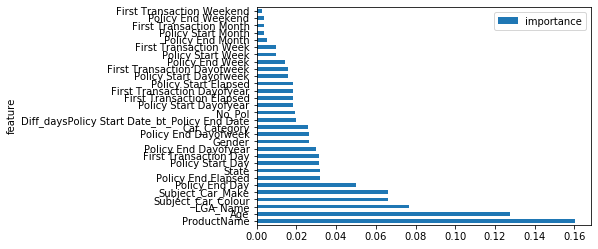

In [75]:
plot_fi(fi[:30]);

In [93]:
to_keep = fi[fi.importance>0.005].feature
len(to_keep)

26

In [94]:
X_train = X_train[to_keep]

In [95]:
X_val = X_val[to_keep]

In [79]:
m = RandomForestClassifier(n_jobs=-1, n_estimators = 1000, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features=  1.0)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.2641509433962264


array([[2094,  107],
       [ 166,   49]])

#### Remove correlated feats

In [80]:
def corr_drop(corr_m, factor=.9):
    """
    Drop correlated features maintaining the most relevant.
    
    Parameters
    ----------
    corr_m : pandas.DataFrame
        Correlation matrix
    factor : float
        Min correlation level   
    
    Returns
    ----------
    pandas.DataFrame
        Correlation matrix only with most relevant features
    """
    global cm
    cm = corr_m
    # Get correlation score, as high as this score, more chances to be dropped.
    cum_corr = cm.applymap(abs).sum()
    def remove_corr():
        global cm
        for col in cm.columns:
            for ind in cm.index:
                if (ind in cm.columns) and (col in cm.index):
                    # Compare if are high correlated.
                    if (cm.loc[ind,col] > factor) and (ind!=col):
                        cum = cum_corr[[ind,col]].sort_values(ascending=False)
                        cm.drop(cum.index[0], axis=0, inplace=True)
                        cm.drop(cum.index[0], axis=1, inplace=True)
                        # Do recursion until the last high correlated.
                        remove_corr()
        return cm
    return remove_corr()

In [96]:
to_keep = corr_drop(X_train[to_keep].corr(method = 'spearman',min_periods = 2), 0.999).columns

In [97]:
len(to_keep)

21

In [98]:
to_keep

Index(['ProductName', 'Age', 'LGA_Name', 'Subject_Car_Colour',
       'Subject_Car_Make', 'Policy End Day', 'Policy End Elapsed', 'State',
       'First Transaction Day', 'Policy End Dayofyear', 'Gender',
       'Policy End Dayofweek', 'Car_Category',
       'Diff_daysPolicy Start Date_bt_Policy End Date', 'No_Pol',
       'First Transaction Dayofyear', 'Policy Start Elapsed',
       'First Transaction Dayofweek', 'Policy End Week',
       'First Transaction Week', 'Policy End Month'],
      dtype='object')

In [99]:
X_train = X_train[to_keep]

In [100]:
X_val = X_val[to_keep]

In [101]:
m = RandomForestClassifier(n_jobs=-1, n_estimators = 1000, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features=  1.0)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.26595744680851063


array([[2090,  111],
       [ 165,   50]])

In [102]:
import scipy
from scipy.cluster import hierarchy as hc

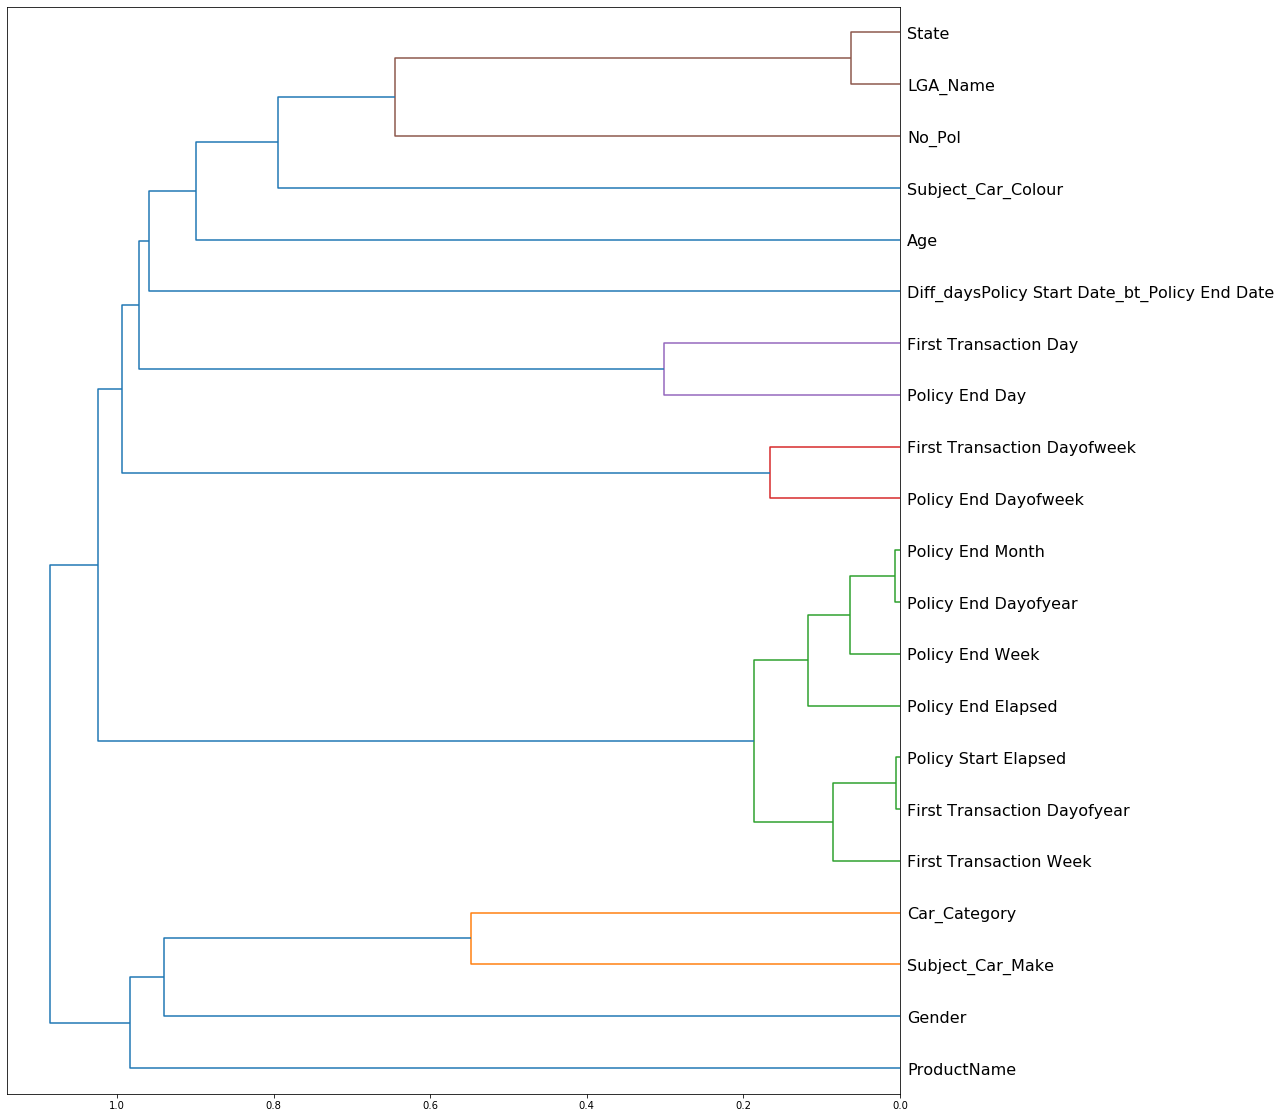

In [103]:
corr = np.round(scipy.stats.spearmanr(X_train[to_keep]).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,20))
dendrogram = hc.dendrogram(z, labels=X_train[to_keep].columns, orientation='left', leaf_font_size=16)
plt.show()

In [104]:
imp = pimp_feat_importance(m, X_val, y_val, 
                                        scoring = 'f1')

In [105]:
imp

,feature,importance
4,Subject_Car_Make,0.11788
0,ProductName,0.07986
1,Age,0.07490
9,Policy End Dayofyear,0.03341
12,Car_Category,0.03264
6,Policy End Elapsed,0.02077
14,No_Pol,0.01041
2,LGA_Name,0.00921
8,First Transaction Day,0.00610
18,Policy End Week,0.00592


In [106]:
imp[imp.importance<0]

,feature,importance
3,Subject_Car_Colour,-0.00866
17,First Transaction Dayofweek,-0.01034
10,Gender,-0.01066
11,Policy End Dayofweek,-0.01339


In [107]:
to_keep = list(imp[imp.importance >= 0].feature)

In [108]:
X_train= X_train[to_keep]
X_val = X_val[to_keep]

In [109]:
m = RandomForestClassifier(n_jobs=-1, n_estimators = 1000, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features=  1.0)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.29314420803782504


array([[2055,  146],
       [ 153,   62]])

In [110]:
imp = pimp_feat_importance(m, X_val, y_val, 
                                        scoring = 'f1')

In [111]:
imp

,feature,importance
0,Subject_Car_Make,0.12760
2,Age,0.08609
1,ProductName,0.08478
3,Policy End Dayofyear,0.01820
7,LGA_Name,0.01278
6,No_Pol,0.00813
8,First Transaction Day,0.00705
5,Policy End Elapsed,0.00669
9,Policy End Week,0.00358
12,Policy End Day,0.00316


In [112]:
to_keep = list(imp[imp.importance >= 0].feature)

In [113]:
X_train= X_train[to_keep]
X_val = X_val[to_keep]

In [114]:
m = RandomForestClassifier(n_jobs=-1, n_estimators = 1000, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features=  1.0)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.2997658079625293


array([[2053,  148],
       [ 151,   64]])

In [115]:
imp = pimp_feat_importance(m, X_val, y_val, 
                                        scoring = 'f1')

In [116]:
imp

,feature,importance
0,Subject_Car_Make,0.13669
1,Age,0.08876
2,ProductName,0.08674
3,Policy End Dayofyear,0.01802
4,LGA_Name,0.01657
6,First Transaction Day,0.01325
9,Policy End Day,0.01201
7,Policy End Elapsed,0.00674
8,Policy End Week,0.00457
5,No_Pol,0.00454


In [117]:
to_keep = list(imp[imp.importance >= 0].feature)

In [118]:
X_train= X_train[to_keep]
X_val = X_val[to_keep]

In [119]:
m = RandomForestClassifier(n_jobs=-1, n_estimators = 1000, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features=  1.0)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.2971698113207547


array([[2055,  146],
       [ 152,   63]])

In [120]:
imp = pimp_feat_importance(m, X_val, y_val, 
                                        scoring = 'f1')

In [121]:
imp

,feature,importance
0,Subject_Car_Make,0.13865
1,Age,0.09034
2,ProductName,0.08766
3,Policy End Dayofyear,0.02031
6,Policy End Day,0.01447
4,LGA_Name,0.01295
5,First Transaction Day,0.01148
8,Policy End Week,0.00735
9,No_Pol,0.00675
7,Policy End Elapsed,0.00665


In [131]:
to_keep = list(imp[imp.importance >= 0].feature)

In [132]:
to_keep

['Subject_Car_Make',
 'Age',
 'ProductName',
 'Policy End Dayofyear',
 'Policy End Day',
 'LGA_Name',
 'First Transaction Day',
 'Policy End Week',
 'No_Pol',
 'Policy End Elapsed',
 'First Transaction Week',
 'Policy Start Elapsed']

In [136]:
X_train= X_train[to_keep]
X_val = X_val[to_keep]

In [137]:
m = RandomForestClassifier(n_jobs=-1, n_estimators = 1000, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features=  1.0)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.3073394495412844


array([[2047,  154],
       [ 148,   67]])

In [138]:
imp = pimp_feat_importance(m, X_val, y_val, 
                                        scoring = 'f1')

In [139]:
imp

,feature,importance
0,Subject_Car_Make,0.13947
1,Age,0.09541
2,ProductName,0.09041
3,Policy End Dayofyear,0.02269
4,Policy End Day,0.01434
5,LGA_Name,0.01417
6,First Transaction Day,0.01302
9,Policy End Elapsed,0.01133
8,No_Pol,0.00886
7,Policy End Week,0.00250


In [140]:
imp.to_csv(path/'data/raw/feature_importance_perm_rf.csv')

In [141]:
list(imp.feature)

['Subject_Car_Make',
 'Age',
 'ProductName',
 'Policy End Dayofyear',
 'Policy End Day',
 'LGA_Name',
 'First Transaction Day',
 'Policy End Elapsed',
 'No_Pol',
 'Policy End Week',
 'First Transaction Week',
 'Policy Start Elapsed']

In [142]:
df_train_keep = X_train.copy()

In [143]:
df_train_keep['target'] = y_train

In [144]:
df_val_keep = X_val.copy()

In [145]:
df_val_keep['target'] = y_val

In [146]:
df_train_keep.to_feather(path/'data/ready/train_keep.fth')

In [147]:
df_val_keep.to_feather(path/'data/ready/val_keep.fth')

## Test

### Load data

In [148]:
df_test = pd.read_csv(path/'Test.csv', parse_dates=['Policy Start Date','Policy End Date',
                                                     'First Transaction Date'])

In [149]:
df_test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [150]:
df_test.shape

(1202, 13)

In [151]:
df_test.describe()

,Age,No_Pol
count,1202.00000,1202.00000
mean,43.79285,1.25790
std,19.98624,0.61351
min,-26.00000,1.00000
25%,35.00000,1.00000
50%,41.00000,1.00000
75%,50.00000,1.00000
max,120.00000,7.00000


In [152]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 13 columns):
ID                        1202 non-null object
Policy Start Date         1202 non-null datetime64[ns]
Policy End Date           1202 non-null datetime64[ns]
Gender                    1161 non-null object
Age                       1202 non-null int64
First Transaction Date    1202 non-null datetime64[ns]
No_Pol                    1202 non-null int64
Car_Category              830 non-null object
Subject_Car_Colour        505 non-null object
Subject_Car_Make          954 non-null object
LGA_Name                  546 non-null object
State                     546 non-null object
ProductName               1202 non-null object
dtypes: datetime64[ns](3), int64(2), object(8)
memory usage: 122.2+ KB


In [153]:
min(df_test['Policy Start Date'])

Timestamp('2010-01-01 00:00:00')

In [154]:
max(df_test['Policy Start Date'])

Timestamp('2010-12-31 00:00:00')

### Data preparation

In [155]:
df_test['Policy Start Date'] = pd.to_datetime(df_test['Policy Start Date'] )
df_test['Policy End Date'] = pd.to_datetime(df_test['Policy End Date'] )
df_test['First Transaction Date'] = pd.to_datetime(df_test['First Transaction Date'] )

In [156]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 13 columns):
ID                        1202 non-null object
Policy Start Date         1202 non-null datetime64[ns]
Policy End Date           1202 non-null datetime64[ns]
Gender                    1161 non-null object
Age                       1202 non-null int64
First Transaction Date    1202 non-null datetime64[ns]
No_Pol                    1202 non-null int64
Car_Category              830 non-null object
Subject_Car_Colour        505 non-null object
Subject_Car_Make          954 non-null object
LGA_Name                  546 non-null object
State                     546 non-null object
ProductName               1202 non-null object
dtypes: datetime64[ns](3), int64(2), object(8)
memory usage: 122.2+ KB


In [157]:
df_test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


#### Adding timedelta

In [158]:
timedelta_with_general_date(df_test, 'Policy Start Date',drop = False)

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,Diff_daysPolicy Start Date_bt_First Transaction Date,Diff_monthPolicy Start Date_bt_First Transaction Date,Diff_yearPolicy Start Date_bt_First Transaction Date,Diff_daysPolicy Start Date_bt_Policy End Date,Diff_monthPolicy Start Date_bt_Policy End Date,Diff_yearPolicy Start Date_bt_Policy End Date
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic,0.00000,0.00000,0.00000,-364.00000,-12.00000,-1.00000
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic,0.00000,0.00000,0.00000,-364.00000,-12.00000,-1.00000
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic,0.00000,0.00000,0.00000,-364.00000,-12.00000,-1.00000
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe,0.00000,0.00000,0.00000,-364.00000,-12.00000,-1.00000
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic,0.00000,0.00000,0.00000,-364.00000,-12.00000,-1.00000
5,ID_04OFD80,2010-09-25,2011-06-28,Male,64,2010-09-25,2,NaN,As Attached,TOYOTA,Victoria Island,Lagos,Car Classic,0.00000,0.00000,0.00000,-276.00000,-10.00000,-1.00000
6,ID_04UA1UO,2010-01-18,2011-01-17,Female,120,2010-01-18,1,NaN,As Attached,Hyundai,Victoria Island,Lagos,Car Classic,0.00000,0.00000,0.00000,-364.00000,-12.00000,-1.00000
7,ID_06QWOUO,2010-06-24,2011-06-23,Female,35,2010-06-24,1,Saloon,Black,Honda,Lagos,Lagos,Car Classic,0.00000,0.00000,0.00000,-364.00000,-12.00000,-1.00000
8,ID_06SOU7C,2010-06-27,2011-06-26,NaN,22,2010-06-27,1,JEEP,As Attached,TOYOTA,Victoria Island,Lagos,Car Classic,0.00000,0.00000,0.00000,-364.00000,-12.00000,-1.00000
9,ID_0CRE393,2010-12-18,2011-12-17,Male,38,2010-12-18,3,NaN,NaN,NaN,Obia/Akpor,Obia-Akpor,Car Classic,0.00000,0.00000,0.00000,-364.00000,-12.00000,-1.00000


In [159]:
date_cols = df_test.select_dtypes(include = ['datetime64[ns]']).columns

In [160]:
for date in date_cols:
    add_datepart(df_test,date,drop=False)

In [161]:
date_cols

Index(['Policy Start Date', 'Policy End Date', 'First Transaction Date'], dtype='object')

In [162]:
df_test.drop(columns = date_cols, inplace = True)

#### Encode categoricals

In [163]:
with open(path/'CatPrep.pkl', 'rb') as f:
    EncodeCategorical = pickle.load(f)

In [164]:
df_test.drop(columns='ID').select_dtypes(include='object').head()

,Gender,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,Female,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,Male,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,Female,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,Female,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,NaN,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [165]:
for i in list(EncodeCategorical.categories):
    if i not in df_test.columns:
        EncodeCategorical.categories.pop(i)
EncodeCategorical.cat_names = list(EncodeCategorical.categories)

In [166]:
EncodeCategorical(df_test,test=True)

In [167]:
df_test[cat_cols].head()

,Gender,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,2,0,0,21,16,8,2
1,4,0,0,0,146,23,2
2,2,9,5,25,240,7,2
3,2,9,0,64,0,0,6
4,0,9,33,27,235,71,2


#### Fixmissing

In [168]:
# with open(path/'FixMiss.pkl', 'rb') as f:
#     FixMiss = pickle.load(f)

In [169]:
df_test.isnull().sum().sum()

0

In [170]:
df_preds = df_test.copy()

#### Save ready_test

In [171]:
df_test= df_test[to_keep]

In [172]:
df_test.reset_index(inplace = True, drop = True)

In [173]:
df_test.head()

,Subject_Car_Make,Age,ProductName,Policy End Dayofyear,Policy End Day,LGA_Name,First Transaction Day,Policy End Week,No_Pol,Policy End Elapsed,First Transaction Week,Policy Start Elapsed
0,21,46,2,295,22,16,23,42,1,1319241600.00000,42,1287792000.00000
1,0,32,2,286,13,146,14,41,1,1318464000.00000,41,1287014400.00000
2,25,45,2,240,28,240,29,34,2,1314489600.00000,34,1283040000.00000
3,64,58,6,163,12,0,13,23,1,1307836800.00000,23,1276387200.00000
4,27,120,2,181,30,235,1,26,1,1309392000.00000,26,1277942400.00000


In [174]:
df_test.to_csv(path/'data/ready/test.fth')

In [175]:
X_test = df_test.copy()

## Predict

In [176]:
df_train = pd.read_feather(path/'data/ready/train_keep.fth')

In [177]:
df_val = pd.read_feather(path/'data/ready/val_keep.fth')

In [178]:
frames = [df_train,df_val]

df_full =pd.concat(frames)

In [179]:
X_train = df_full[to_keep]

In [180]:
X_test = df_test[to_keep]

In [182]:
y_train = df_full.target

In [188]:
m =RandomForestClassifier(n_jobs=-1, n_estimators = 1000, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features= 1.0)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_test)

Training model


In [189]:
df_preds['target'] = y_pred

In [190]:
df_preds.target.value_counts()

0    1170
1      32
Name: target, dtype: int64

In [191]:
df_preds[['ID','target']].to_csv('19052021.csv', index=False)

In [192]:
pkl_filename = path/"models/rf.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(m, file)